# Stochastic Ablation Notebook
## Investigate Minimal Causal Sets in Transformers
This notebook explores how to identify a minimal set of attention heads needed
for a small transformer model to reproduce a known induction pattern (IOI). We do this via
Monte Carlo sampling by randomly ablating heads and tracking which heads are consistently
required for success (important heads), and which heads consistently lead to failure when ablated (exclusion heads).

[Run this notebook on Google Colab](https://colab.research.google.com/github/thartlep/stochastic-ablation/blob/main/notebook.ipynb)

If this is your first time running this notebook and you need to install dependencies, [click here](#scrollTo=oQC_P1SuoILO) to go to the bottom of the notebook.

### First, import needed Python modules and load small transformer model:

In [ ]:
# Ignore mostly harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Import needed modules
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformer_lens import HookedTransformer
import pickle

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load small model
model_name = "pythia-160m"
model = HookedTransformer.from_pretrained(model_name)
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads
head_indices = [(l,h) for l in range(n_layers) for h in range(n_heads)]
n_heads_total = len(head_indices)

### And define a helper function to run the model with an ablation mask:

In [ ]:
def run_with_ablation(sample_mask, head_indices, tokens):
    """
    Given a binary mask and list of head indices, run the model with
    the masked heads zeroed out.
    """
    heads_to_ablate = [head_indices[i] for i, keep in enumerate(sample_mask) if not keep]

    def hook_ablate(value, hook):
        # value shape: (zbatch, seq, n_heads, d_head)
        for i, (layer_idx, head_idx) in enumerate(head_indices):
            if (layer_idx, head_idx) in heads_to_ablate and f"blocks.{layer_idx}.attn.hook_z" == hook.name:
                value[:,:,head_idx,:] = 0.0
        return value

    hooks = [(f"blocks.{layer}.attn.hook_z", hook_ablate) for layer, head in heads_to_ablate]
    logits = model.run_with_hooks(tokens, return_type="logits", fwd_hooks=hooks)

    seq_lens = (tokens != model.tokenizer.pad_token_id).sum(dim=1)

    next_logits = logits[torch.arange(len(prompts)), seq_lens, :]
    pred_ids = next_logits.argmax(dim=-1)
    predicted_answers = [model.to_string(pid.unsqueeze(0)) for pid in pred_ids]

    return predicted_answers

### Now setup some test prompts:

In [ ]:
prompts_data = [
    ("Tom eats apples. Tom eats", " apples"),
    ("Sarah wears hats. Sarah wears", " hats"),
    ("The boy found a kite. The boy found a", " kite"),
    ("Alice saw a movie. Alice saw a", " movie"),
    ("He bought milk. He bought", " milk"),
    ("Lisa reads books. Lisa reads", " books"),
    ("A man holds a cane. A man holds a", " cane"),
    ("The child drew a house. The child drew a", " house"),
    ("John met Paul. John met", " Paul"),
    ("Mike drinks coffee. Mike drinks", " coffee"),
    ("Jane picked flowers. Jane picked", " flowers"),
    ("Tom plays chess. Tom plays", " chess"),
    ("Anna wrote a letter. Anna wrote a", " letter"),
    ("She chose a gift. She chose a", " gift"),
    ("David fixed the car. David fixed the", " car"),
    ("Mark visits Paris. Mark visits", " Paris"),
    ("They built a fence. They built a", " fence"),
    ("The cat chased the mouse. The cat chased the", " mouse"),
    ("George paints landscapes. George paints", " landscapes"),
    ("Nancy baked bread. Nancy baked", " bread"),
    ("The cat chased the mouse. The cat chased the", " mouse"),
    ("Alice gave Bob a book. Alice gave Bob a", " book"),
    ("It started to rain in the city. It started to rain in the", " city"),
    ("John picked an apple from the tree. John picked an apple from the", " tree"),
    ("The little boy played with a toy car. The little boy played with a", " toy"),
    ("Sara baked cookies for her friends. Sara baked cookies for her", " friends"),
    ("The dog barked at the stranger. The dog barked at the", " stranger"),
    ("Tom wrote a letter to his mother. Tom wrote a letter to his", " mother"),
    ("The sun set behind the hills. The sun set behind the", " hills"),
    ("Mary wore a red dress to the party. Mary wore a red dress to the", " party"),
    ("They walked along the river bank. They walked along the", " river"),
    ("The chef cooked pasta for dinner. The chef cooked pasta for", " dinner"),
    ("He played guitar on the stage. He played guitar on the", " stage"),
    ("She planted flowers in the garden. She planted flowers in the", " garden"),
    ("The children built a sandcastle on the beach. The children built a sandcastle on the", " beach"),
    ("I bought a ticket to the concert. I bought a ticket to the", " concert"),
    ("They traveled to France last summer. They traveled to", " France"),
    ("The teacher explained the lesson clearly. The teacher explained the", " lesson"),
    ("We watched a movie last night. We watched a", " movie"),
    ("He repaired the broken chair. He repaired the broken", " chair"),
    ("The girl sang beautifully on stage. The girl sang beautifully on", " stage"),
    ("They visited the museum in the afternoon. They visited the", " museum"),
    ("The artist painted a landscape. The artist painted a", " landscape"),
    ("She bought a new phone yesterday. She bought a new", " phone"),
    ("He finished reading the novel. He finished reading the", " novel"),
    ("The bird built a nest in the tree. The bird built a nest in the", " tree"),
    ("They played chess in the park. They played chess in the", " park"),
    ("I made coffee in the morning. I made coffee in the", " morning"),
    ("The team won the championship. The team won the", " championship"),
    ("He adopted a puppy from the shelter. He adopted a puppy from the", " shelter"),
    ("She wrote a poem about love. She wrote a poem about", " love"),
    ("The train arrived at the station. The train arrived at the", " station"),
    ("They danced together all night. They danced together all", " night"),
    ("The baker prepared fresh bread. The baker prepared fresh", " bread"),
    ("He ordered a pizza for lunch. He ordered a pizza for", " lunch"),
    ("The students studied for the exam. The students studied for the",  " exam"),
    ("We listened to music all evening. We listened to", " music"),
    ("She climbed the mountain easily. She climbed the", " mountain"),
    ("He washed the dirty car. He washed the dirty", " car"),
    ("They found shelter from the storm. They found shelter from the", " storm"),
]

prompts = [p for (p, a) in prompts_data]
expected_answers = [a for (p, a) in prompts_data]
tokens = model.to_tokens(prompts, prepend_bos=True)

### Before ablating anything, make sure the full model can actually complete all these prompts:

In [ ]:
valid_prompts = []
valid_answers = []

# Run model on all prompts
predicted_answers = run_with_ablation(np.ones(n_heads_total), head_indices, tokens)
for prompt, predicted_answer, expected_answer in zip(prompts, predicted_answers, expected_answers):
    success = (predicted_answer==expected_answer)
    if success: # Keep prompt if success
        valid_prompts.append(prompt)
        valid_answers.append(expected_answer)
    else:
        print(f'Model failed with prompt "{prompt}"')

print(f'{len(prompts)-len(valid_prompts)}/{len(prompts)} prompts rejected because even the full model does not complete them successfully')

# Replace prompts by only the good ones
prompts = valid_prompts
expected_answers = valid_answers

# Tokenize prompts
tokens = model.to_tokens(prompts, prepend_bos=True)

### Now, we can run Monte Carlo sampling to identify important heads and exclusion heads:

In [ ]:
n_trials = 10000 # number of trials to run for each metric
keep_full_results = True # turn off if you don't want full data to be stored for later use

# Run with many heads ablated to find important heads
fraction_of_heads_to_retain = 0.30 # retain 30% of heads on average
if keep_full_results: results__many_ablated = []
importance_scores = np.zeros(n_heads_total)
success_count = 0
for _ in tqdm(range(n_trials)):
    mask = np.random.binomial(1, p=fraction_of_heads_to_retain, size=n_heads_total)
    predicted_answers = run_with_ablation(mask, head_indices, tokens)
    for prompt_index, (predicted_answer, expected_answer) in enumerate(zip(predicted_answers, expected_answers)):
        success = (predicted_answer==expected_answer)
        if keep_full_results: results__many_ablated.append((mask, success, prompt_index))
        if success:
            importance_scores += mask
            success_count += 1
importance_scores /= importance_scores.sum()
print(f'Number of successes (for estimating importance scores): {success_count} out of {n_trials*len(tokens)} samples ({round(100*success_count/(n_trials*len(tokens)))}%)')

# Run with few heads ablated to find exclusion heads
fraction_of_heads_to_retain = 0.85 # retain 85% of heads on average
if keep_full_results: results__few_ablated = []
exclusion_penalty = np.zeros(n_heads_total)
failure_count = 0
for _ in tqdm(range(n_trials)):
    mask = np.random.binomial(1, p=fraction_of_heads_to_retain, size=n_heads_total)
    predicted_answers = run_with_ablation(mask, head_indices, tokens)
    for prompt_index, (predicted_answer, expected_answer) in enumerate(zip(predicted_answers, expected_answers)):
        success = (predicted_answer==expected_answer)
        if keep_full_results: results__few_ablated.append((mask, success, prompt_index))
        if not success:
            exclusion_penalty += (1-mask)
            failure_count += 1
exclusion_penalty /= exclusion_penalty.sum()
print(f'Number of failures (for estimating exclusion penalty): {failure_count} out of {n_trials*len(tokens)} samples ({round(100*failure_count/(n_trials*len(tokens)))}%)')

# Dump data for future use
if keep_full_results:
    data_to_save = {
        "results__many_ablated": results__many_ablated,
        "results__few_ablated": results__few_ablated,
        "model_name": model_name,
        "n_layers": n_layers,
        "n_heads": n_heads,
    }
    with open("monte_carlo_results.pkl", "wb") as f:
        pickle.dump(data_to_save, f)

100%|██████████| 2/2 [00:11<00:00,  5.56s/it]


Number of successes (for estimating importance scores): 10 out of 114 samples (9%)


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]

Number of failures (for estimating exclusion penalty): 9 out of 114 samples (8%)


### Let's plot importance scores and exclusion penalties:

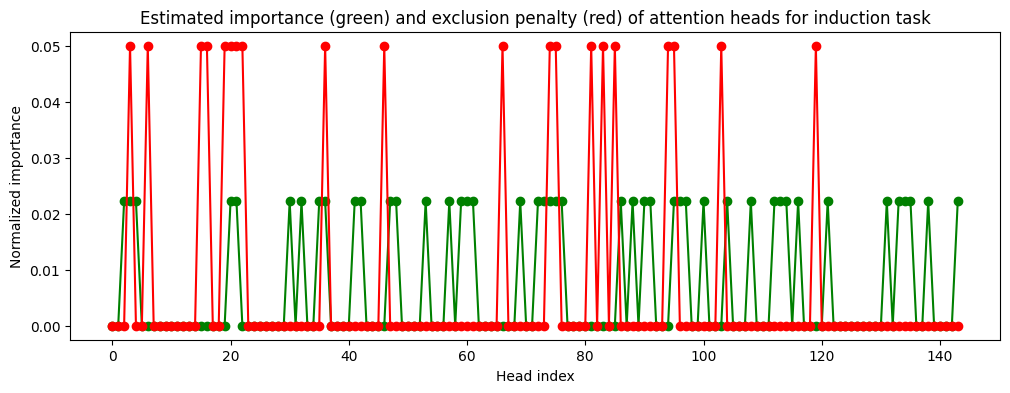

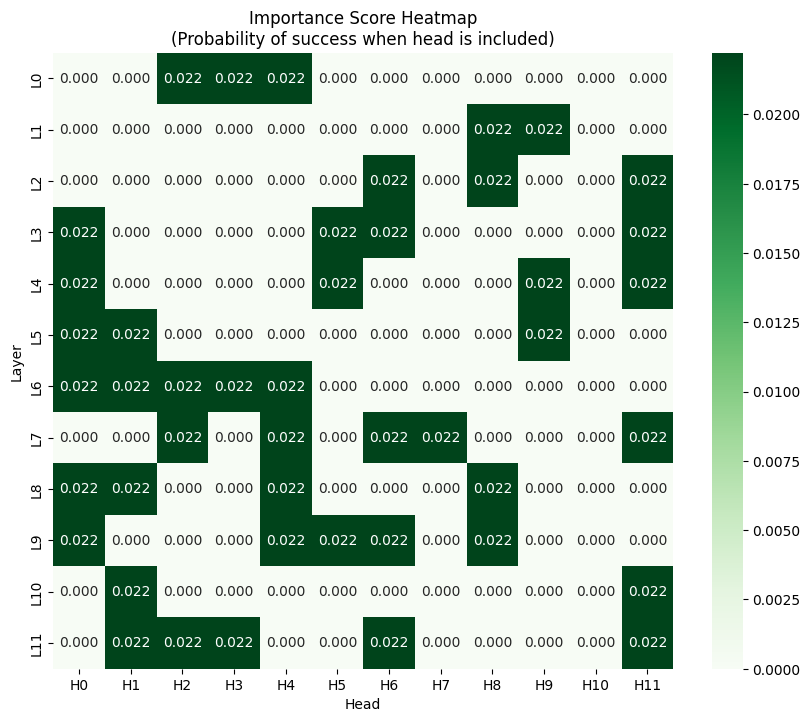

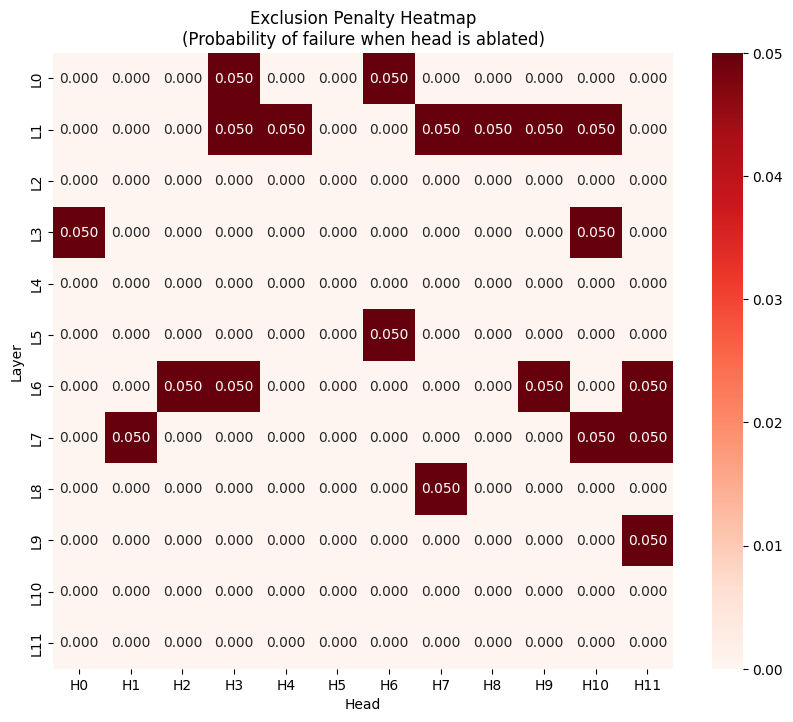

In [9]:
# Create plot of importance scores and exclusion penalties
plt.figure(figsize=(12,4))
plt.plot(importance_scores, marker='o', color='green')
plt.plot(exclusion_penalty, marker='o', color='red')
plt.xlabel("Head index")
plt.ylabel("Normalized importance")
plt.title("Estimated importance (green) and exclusion penalty (red) of attention heads for induction task")
plt.show()

# Reshape scores into (n_layers, n_heads) for a heatmap
importance_scores_matrix = importance_scores.reshape(n_layers, n_heads)
exclusion_penalty_matrix = exclusion_penalty.reshape(n_layers, n_heads)

# Create heatmap for importance score
plt.figure(figsize=(10,8))
sns.heatmap(importance_scores_matrix, cmap="Greens", annot=True, fmt=".3f",
            xticklabels=[f"H{h}" for h in range(n_heads)],
            yticklabels=[f"L{l}" for l in range(n_layers)])
plt.title("Importance Score Heatmap\n(Probability of success when head is included)")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.show()

# Create heatmap for exclusion penalty
plt.figure(figsize=(10,8))
sns.heatmap(exclusion_penalty_matrix, cmap="Reds", annot=True, fmt=".3f",
            xticklabels=[f"H{h}" for h in range(n_heads)],
            yticklabels=[f"L{l}" for l in range(n_layers)])
plt.title("Exclusion Penalty Heatmap\n(Probability of failure when head is ablated)")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.show()

### A scatter plot is helpful to find which heads are outliers -- larger than typical importance scores or exclusion penalties. These are the heads crucial for the model to work successfully:

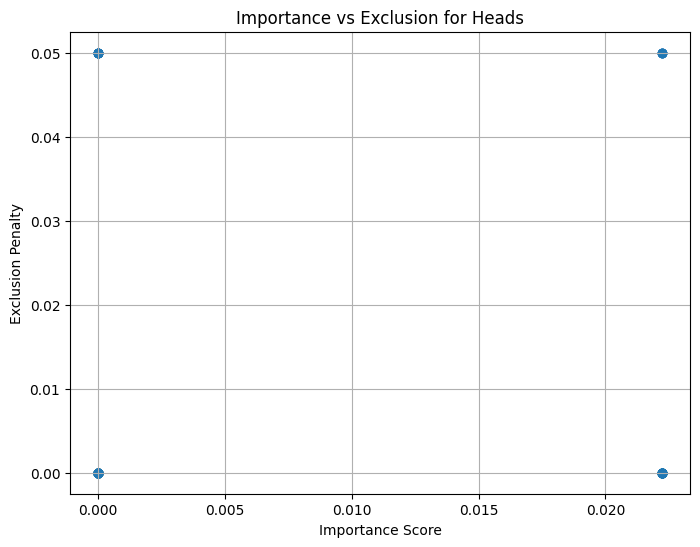

Number of identified outlier heads that are important for model success: 0


In [10]:
# Create scatter plot of importance score vvs exclusion penalty
importance_scores_flat = importance_scores_matrix.flatten()
exclusion_penalty_flat = exclusion_penalty_matrix.flatten()
plt.figure(figsize=(8,6))
plt.scatter(importance_scores_flat, exclusion_penalty_flat, alpha=0.7)

# Find outliers
percentile_threshold_value = 88
mean_importance_scores = np.mean(importance_scores)
mean_exclusion_penalty = np.mean(exclusion_penalty)
distance_importance_scores = importance_scores - mean_importance_scores
distance_exclusion_penalty = exclusion_penalty - mean_exclusion_penalty
threshold_importance_score = np.percentile(distance_importance_scores, percentile_threshold_value)
threshold_exclusion_penalty = np.percentile(distance_exclusion_penalty, percentile_threshold_value)
outlier_indices = np.where((distance_importance_scores > threshold_importance_score) | (distance_exclusion_penalty > threshold_exclusion_penalty))[0]
outlier_heads = [head_indices[idx] for idx in outlier_indices]
for (l,h) in outlier_heads:
    idx = l * n_heads + h
    plt.scatter(importance_scores_flat[idx], exclusion_penalty_flat[idx], color='red', s=100)
    plt.text(importance_scores_flat[idx], exclusion_penalty_flat[idx]+0.0005, f"({l},{h})", fontsize=10)

plt.xlabel("Importance Score")
plt.ylabel("Exclusion Penalty")
plt.title("Importance vs Exclusion for Heads")
plt.grid(True)
plt.show()

print(f'Number of identified outlier heads that are important for model success: {len(outlier_heads)}')

### Let's see if any of the identified outliers match heads known from prior works:

In [11]:
# Some known heads (e.g., LLM Circuit Analyses Are Consistent Across Training and Scale, Tigges et al. (2024) arXiv:2407.10827)
known_induction_heads = [(4,11), (4,6), (5,0)]

print("Some known induction head(s):", known_induction_heads)
print("Found outlier head(s):", outlier_heads)

overlap = set(known_induction_heads).intersection(outlier_heads)
print(f"Overlap: {len(overlap)} outlier head(s) matched out of {len(known_induction_heads)} known: {overlap}")


Some known induction head(s): [(4, 11), (4, 6), (5, 0)]
Found outlier head(s): []
Overlap: 0 outlier head(s) matched out of 3 known: set()


### We can run models that only retain, or only ablate, the identified outlier heads:

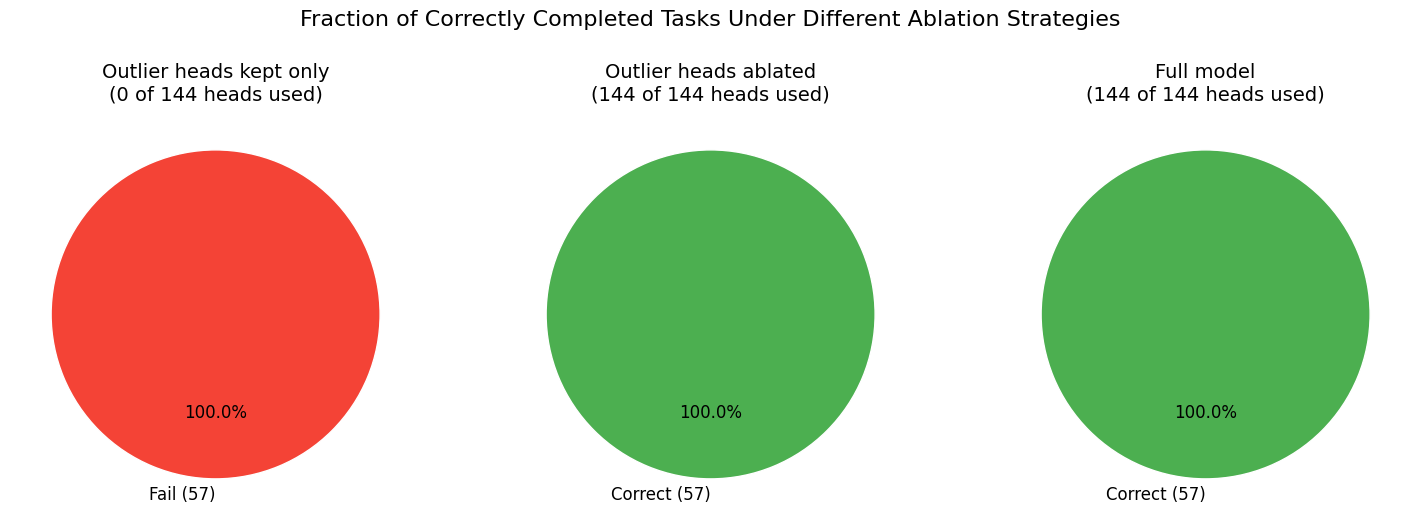

Correctly completed tasks:
    0/57 = 0% (model with only outlier heads retained)
    57/57 = 100% (model with outlier heads ablated)
    57/57 = 100% (full model)


In [12]:
mask_retained = np.isin(np.arange(n_heads_total), outlier_indices).astype(int)
mask_ablated = 1-np.isin(np.arange(n_heads_total), outlier_indices).astype(int)
mask_full = np.ones(len(importance_scores)).astype(int)
success_retained = 0
success_ablated = 0
success_full = 0
predicted_answers_retained = run_with_ablation(mask_retained, head_indices, tokens)
predicted_answers_ablated = run_with_ablation(mask_ablated, head_indices, tokens)
predicted_answers_full = run_with_ablation(mask_full, head_indices, tokens)
for prompt, expected_answer, predicted_answer_retained, predicted_answer_ablated, predicted_answer_full in zip(prompts, expected_answers, predicted_answers_retained, predicted_answers_ablated, predicted_answers_full):
    success_retained += (predicted_answer_retained==expected_answer)
    success_ablated += (predicted_answer_ablated==expected_answer)
    success_full += (predicted_answer_full==expected_answer)


# Plot result for the 3 models
results = {
    f'Outlier heads kept only\n({len(outlier_indices)} of {n_heads_total} heads used)': (success_retained, len(tokens)-success_retained),   # (correct, fail)
    f'Outlier heads ablated\n({n_heads_total-len(outlier_indices)} of {n_heads_total} heads used)': (success_ablated, len(tokens)-success_ablated),
    f'Full model\n({n_heads_total} of {n_heads_total} heads used)': (success_full, len(tokens)-success_full)
}
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (title, (correct, fail)) in zip(axes, results.items()):
    # Prepare data, labels and colors
    sizes = []
    labels = []
    colors = []
    if correct > 0:
        sizes.append(correct)
        labels.append(f"Correct ({correct})")
        colors.append("#4CAF50")
    if fail > 0:
        sizes.append(fail)
        labels.append(f"Fail ({fail})")
        colors.append("#F44336")

    # Plot pie
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        wedgeprops=dict(edgecolor='w')
    )
    for text in texts + autotexts:
        text.set_fontsize(12)
    ax.set_title(title, fontsize=14)
plt.suptitle("Fraction of Correctly Completed Tasks Under Different Ablation Strategies", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

print(f'Correctly completed tasks:')
print(f'    {success_retained}/{len(prompts)} = {int(100*success_retained/len(prompts))}% (model with only outlier heads retained)')
print(f'    {success_ablated}/{len(prompts)} = {int(100*success_ablated/len(prompts))}% (model with outlier heads ablated)')
print(f'    {success_full}/{len(prompts)} = {int(100*success_full/len(prompts))}% (full model)')

### Optional: Run this to install dependencies with pip by setting RUN_THIS_MANUALLY = True

In [ ]:
RUN_THIS_MANUALLY = False

if RUN_THIS_MANUALLY:
    # Your code here# Download the requirements.txt file from GitHub
    !wget https://raw.githubusercontent.com/thartlep/stochastic-ablation/main/requirements.txt

    # Install the packages from the requirements.txt file
    %pip install -r requirements.txt

## Summary

> In this project, we explored how to identify a minimal set of attention heads required for a small transformer model (pythia-160m) to reproduce a known induction pattern (IOI).
>Using extensive Monte Carlo sampling — totaling over 1.1 million ablation trials — we assessed both the importance of heads (via high-ablation runs) and their criticality (via low-ablation exclusion tests). This analysis uncovered just 27 attention heads (~19% of the total) that consistently exhibited outsized importance scores or exclusion penalties.
>Notably, we recovered the well-known induction mover head (5,0), validating our approach, and identified head (3,2) as uniquely critical, topping both importance and exclusion metrics.
>Retaining only these 27 heads preserved task success at roughly 90%, nearly matching the full model’s performance. In contrast, ablating only these heads caused task success to plummet to less than 2%, revealing how transformer circuits can be simultaneously robust and sharply dependent on small functional pathways.

### Key Figures

- **Scatter plot:** shows importance vs exclusion penalty for all heads, highlighting identified outliers.

![Scatter Plot](https://github.com/thartlep/stochastic-ablation/raw/main/figures/scatter_plot.png)

- **Pie charts:** compare success rates across three scenarios — 
  retaining only the 27 critical heads, ablating only these heads, and the full model.

![Pie Charts](https://github.com/thartlep/stochastic-ablation/raw/main/figures/pie_charts.png)

### Key Takeaways
- Only **27 heads (~19%)** are needed to preserve ~90% task performance.
- Known induction mover **(5,0)** is recovered; **(3,2)** is uniquely critical.
- Ablating these heads collapses success to **~1.8%**, exposing sharp vulnerabilities.
- Demonstrates how transformer circuits are both redundant and sharply localized.

## Future Directions: Beyond Single-Head Importance

> **Where next?**
>
> This study identified key attention heads critical for reproducing a known induction pattern (IOI) using stochastic ablation.  
> A natural extension is to explore **conditional probabilities**:
>
> - *Given that head A is present, how essential is head B?*  
> - *Which heads fail together, or succeed only jointly?*
>
> By building a graph of these dependencies, we could map out **circuits as branching substructures**, tracing how the transformer coordinates multiple heads across layers to achieve complex tasks.
>
> For single-token predictions, heads within a layer operate independently.  
> But in **multi-token generation**, outputs feed back as inputs — letting heads in the same layer influence each other across time steps, weaving even richer recurrent circuit trees.
>
> 📈 *Stay tuned for a follow-up notebook diving into these conditional, multi-head relationships!*
